In [1]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import warnings
warnings.filterwarnings('ignore')

import pathlib
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import gala.dynamics as gd
import gala.potential as gp
import jax
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torusimaging as oti
from astropy.constants import G
from gala.units import galactic
from pyia import GaiaData
from astropy.io import fits 
import tqdm
import cmasher as cm
import os
import model_radial_old as model_radial
import astropy.units as u
from scipy import stats
jax.config.update("jax_enable_x64", True)

In [2]:
# LOAD THE DATA
path = '/Users/dhortad/Projects/TorusImaging-radial/data/qiso_df_sim_Rz.fits'
tb = fits.open(path)
data = tb[1].data 

print(len(data))

10000000


In [3]:
# Eilers rotation curve
Rgal = data['R']*u.kpc
Rg = data['Rg']*u.kpc
lz = data['J'][:,1]*u.kpc**2/u.Myr
lz = lz.to((u.kpc*u.km)/u.s)
vcirc = 229. *u.km/u.s
deltaR = Rgal-Rg

#transform to cylindrical velocities
vR = data['v_R']*u.kpc/u.Myr

In [4]:
jr = data['J'][:,0]*u.kpc**2/u.Myr
jr = jr.to(u.km/u.s * u.kpc)

In [5]:
# use APW's function to paint on abundances given correlation with Jr
def make_mgfe(JR, slope=0.1 / 10, std=0.05, rng=None):
    """
    Default parameters from APOGEE in fiducial model
    """
    if rng is None:
        rng = np.random.default_rng()

    x = np.sqrt(JR)
    mgfe = slope * x + 0.0
    mgfe = rng.normal(mgfe, std)
    mgfe_err = np.exp(rng.normal(-4.0, 0.5, size=len(JR)))
    mgfe = rng.normal(mgfe, mgfe_err)
    return mgfe, mgfe_err

lab, lab_err = make_mgfe(jr)

Text(0, 0.5, '$v_R$ [kpc/Myr]')

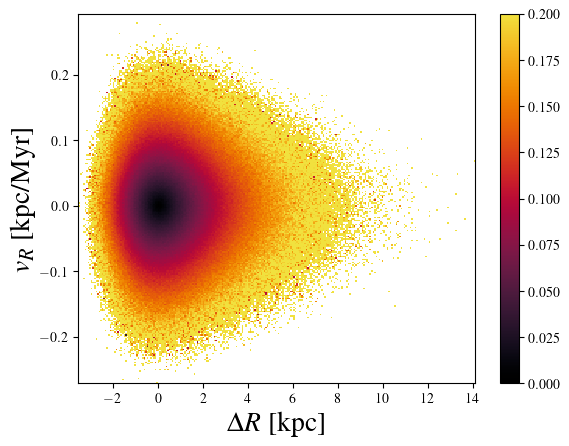

In [6]:
# what does it like for full sample?
binx = np.linspace(np.min(deltaR),np.max(deltaR),256)
biny = np.linspace(np.min(vR.value),np.max(vR.value),256)    
hist = stats.binned_statistic_2d(deltaR.value,vR.value, lab, statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=0.0,vmax=0.2)
plt.colorbar()
plt.xlabel('$\Delta R$ [kpc]', fontsize=20)
plt.ylabel('$v_R$ [kpc/Myr]', fontsize=20)


Text(0, 0.5, '$v_R$ [kpc/Myr]')

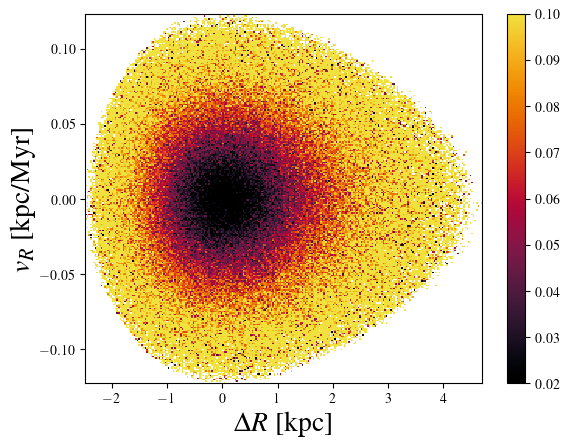

In [7]:
# what about solar vicinity?
mask = (Rg > 8*u.kpc) & (Rg <= 10*u.kpc) & (np.abs(data['z'])<0.2) & (data['v_z']<0.03) &(jr.value<200)
binx = np.linspace(np.min(deltaR[mask]),np.max(deltaR[mask]),256)
biny = np.linspace(np.min(vR.value[mask]),np.max(vR.value[mask]),256)    
hist = stats.binned_statistic_2d(deltaR.value[mask],vR.value[mask], lab[mask], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember, vmin=0.02,vmax=0.1)
plt.colorbar()
plt.xlabel('$\Delta R$ [kpc]', fontsize=20)
plt.ylabel('$v_R$ [kpc/Myr]', fontsize=20)

# model the data

In [8]:
max_deltaR = 4 * u.kpc
max_vR = 0.15 * u.kpc / u.Myr
bins = {
    "pos": np.linspace(-1, 1, 81) * max_deltaR,
    "vel": np.linspace(-1, 1, 81) * max_vR,
}

In [9]:
x_param = deltaR 
y_param = vR 
label = lab
label_err = lab_err

bdata = oti.data.get_binned_label(
    pos=x_param.astype(np.float32),
    vel=y_param.astype(np.float32),
    label=label.astype(np.float32),
    label_err=label_err.astype(np.float32),
    bins=bins,
    units=galactic,
    s_N_thresh=16,
)


In [10]:
# in simulation we see that it is a triangle, so include m=2,3,4 modes. APW says to include m=1 mode too

model, bounds, init_params = model_radial.TorusImaging1DSpline.auto_init(
    bdata,
    label_knots=8,
    e_knots={1: 8, 2: 12, 3: 4, 4: 4},
    label_l2_sigma=1.0,
    label_smooth_sigma=0.5,
    e_l2_sigmas={1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0},
    e_signs={1: -1, 3: -1},
    e_smooth_sigmas={1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1},
    dacc_strength=0.0,
    label_knots_spacing_power=0.75,
    e_knots_spacing_power=0.5,
)


In [11]:
# dunno why but these are initialised differently; doesn't make much difference but APW initialised like this so I ran with it
init_params["e_params"][1]["vals"] = np.full_like(
    init_params["e_params"][1]["vals"], np.log(0.05 / model._label_knots.max())
)
init_params["e_params"][2]["vals"] = np.full_like(
    init_params["e_params"][2]["vals"], -0.5
)
init_params["e_params"][3]["vals"] = np.full_like(
    init_params["e_params"][3]["vals"], np.log(0.05 / model._label_knots.max())
)
init_params["e_params"][4]["vals"] = np.full_like(
    init_params["e_params"][4]["vals"], np.log(0.05 / model._label_knots.max())
)

# Load bootstrap samples

In [17]:
deltaR_boot = np.load('../sav/deltaR_boot.npy', allow_pickle=True)
vRs_boot = np.load('../sav/vRs_boot.npy', allow_pickle=True)
xfe_boot = np.load('../sav/xfe_boot.npy', allow_pickle=True)
xfe_err_boot = np.load('../sav/xfe_err_boot.npy', allow_pickle=True)
deltaR_boot.shape

(15, 10, 50000)

# Plot the first samples to make sure they look ok

15it [01:04,  4.29s/it]


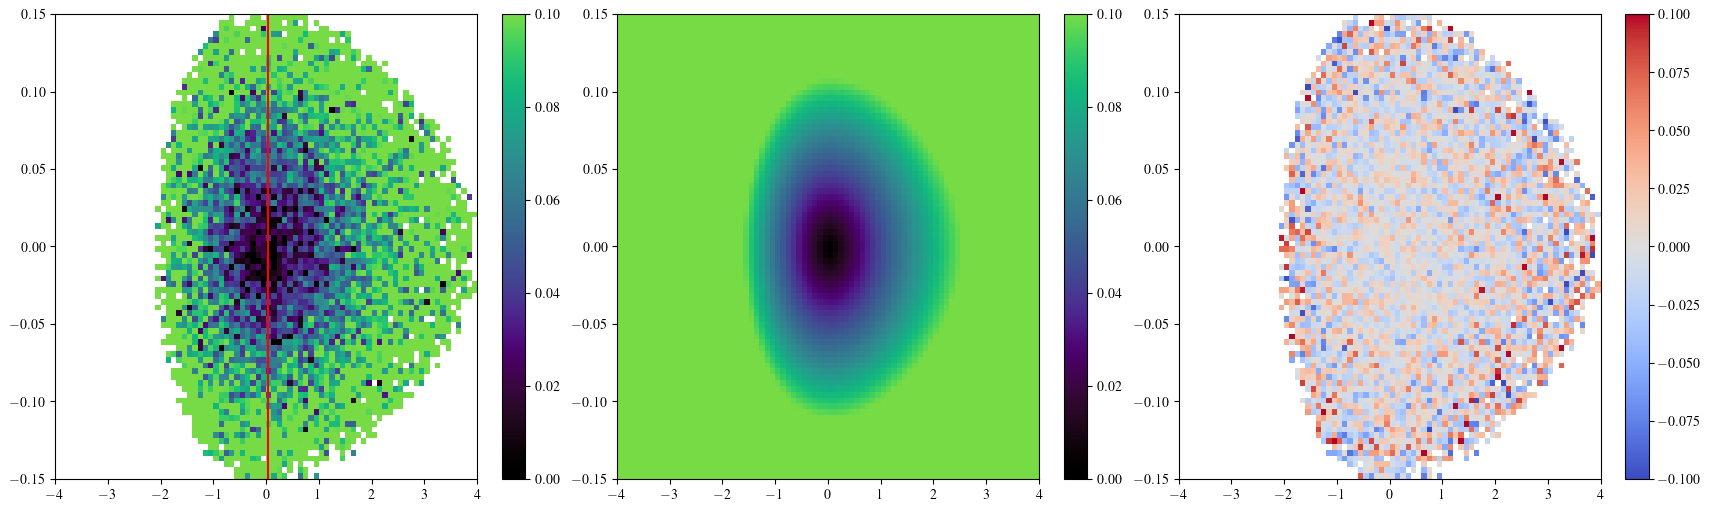

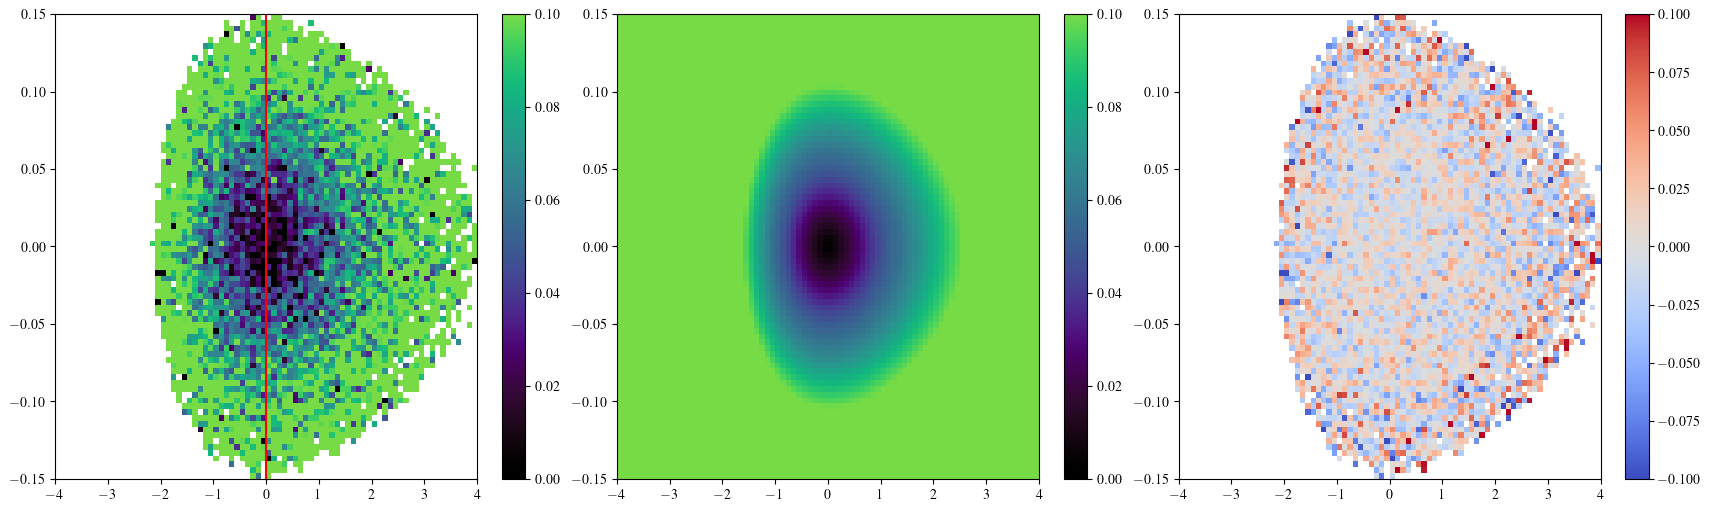

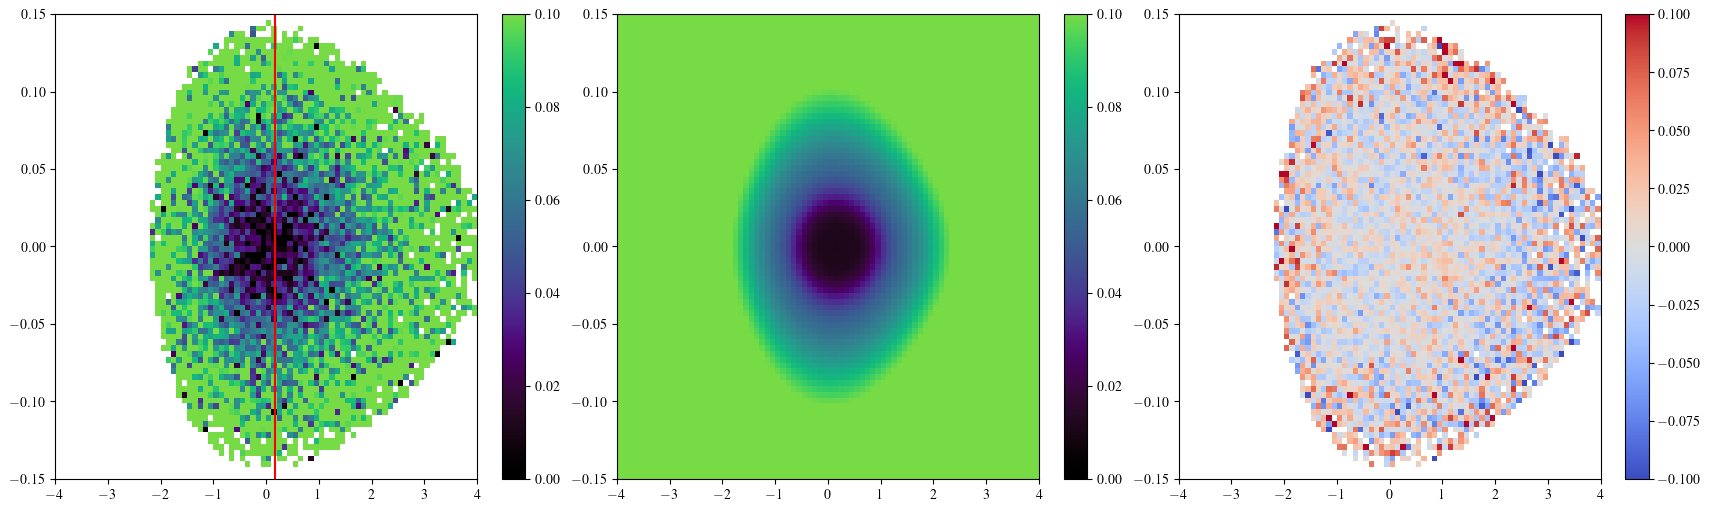

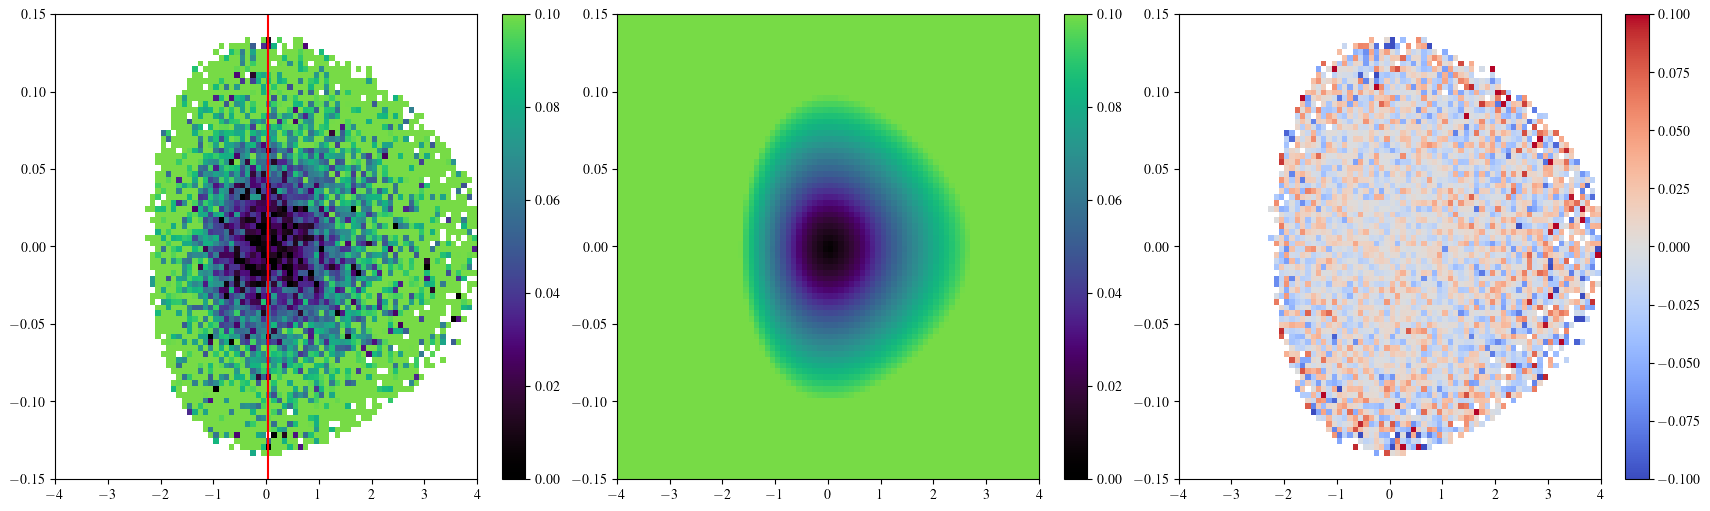

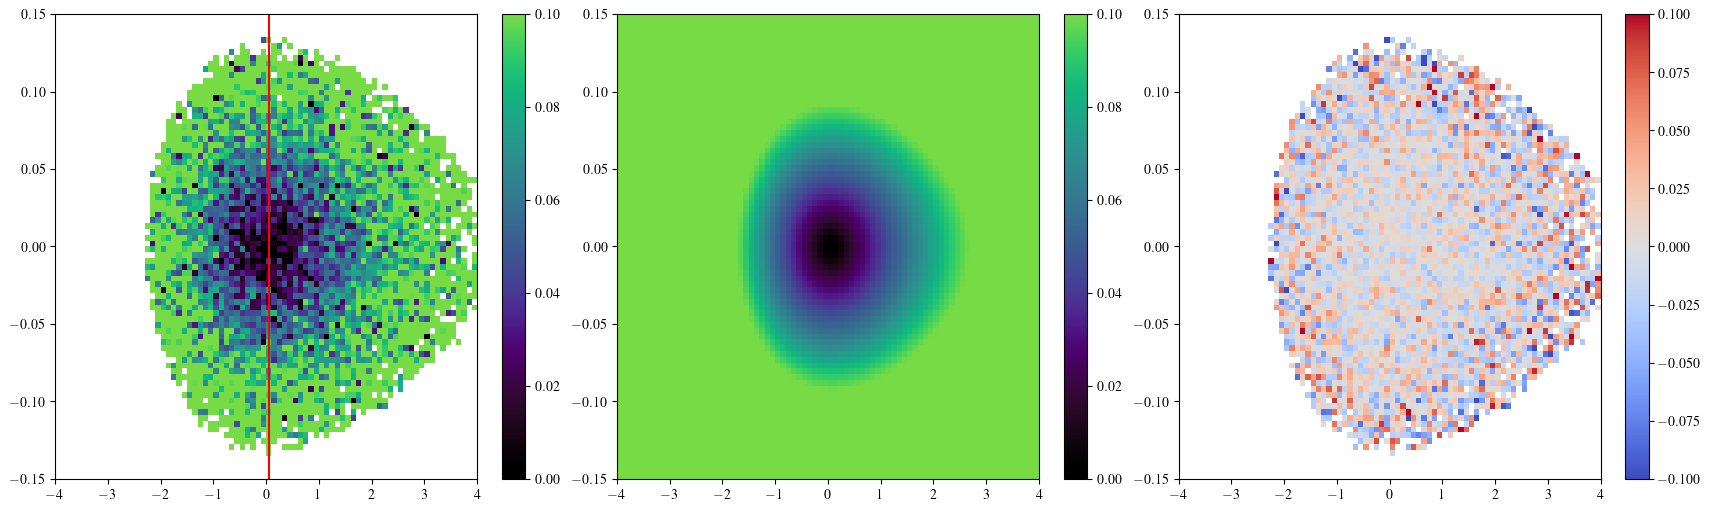

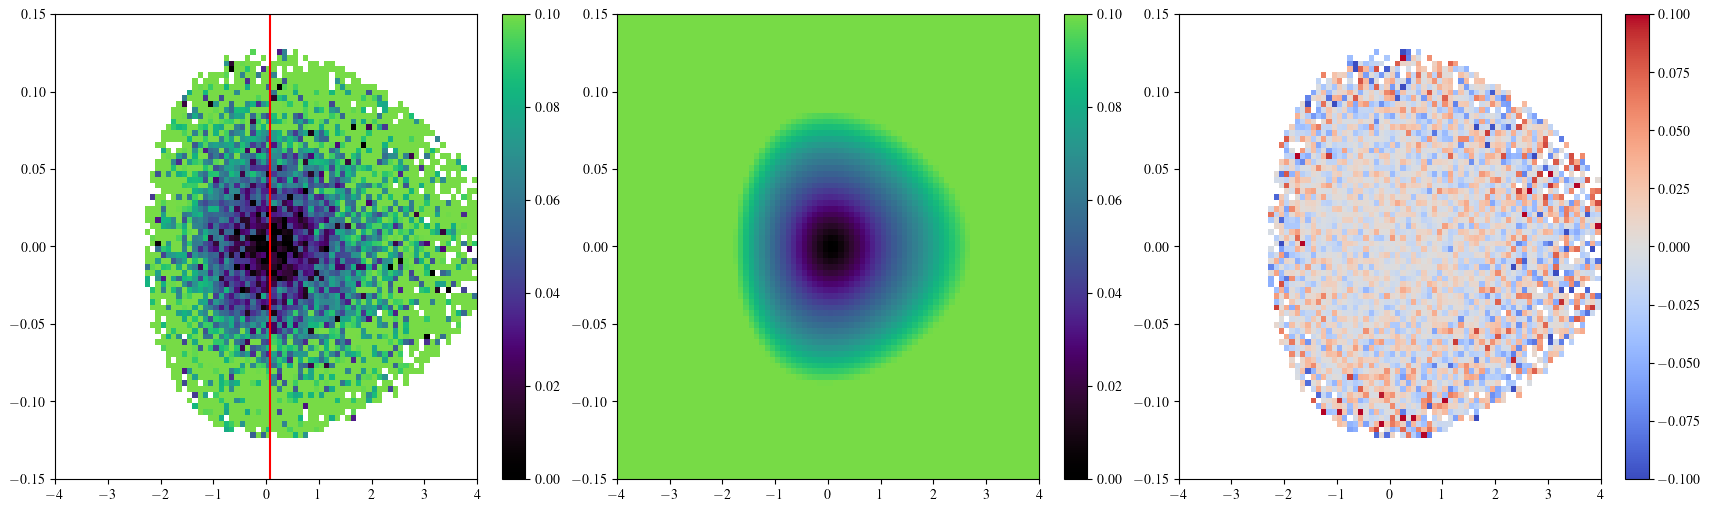

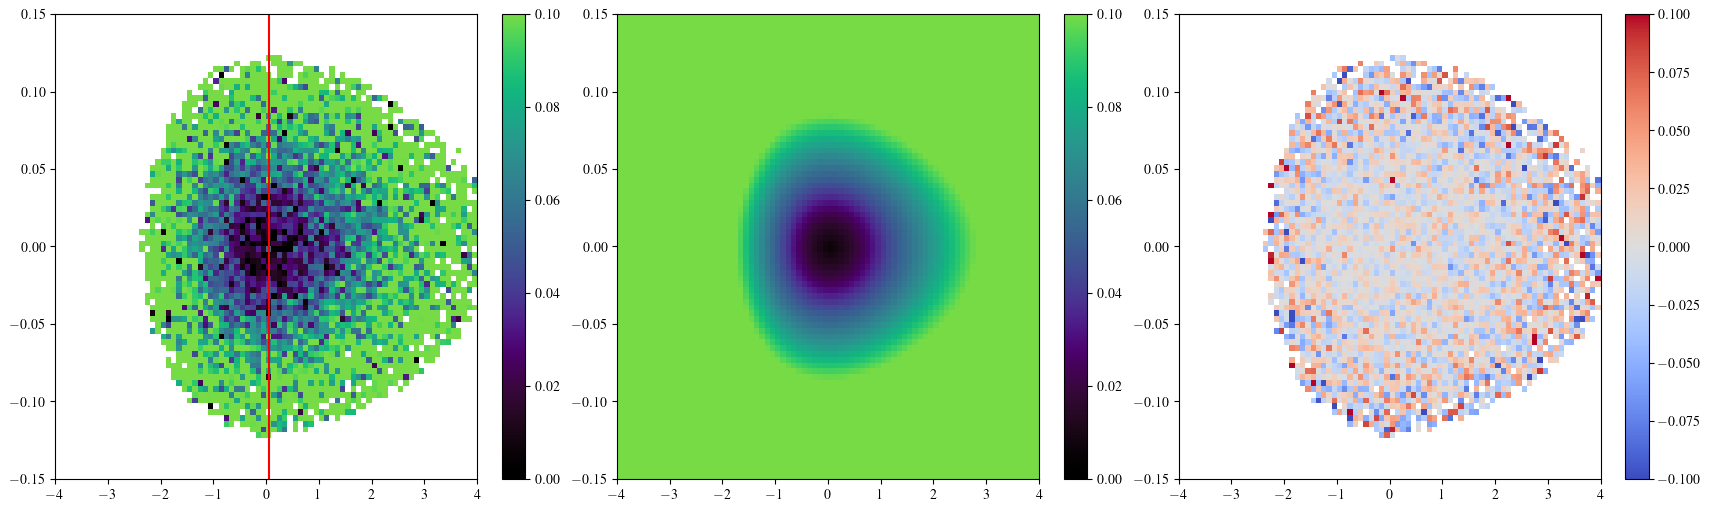

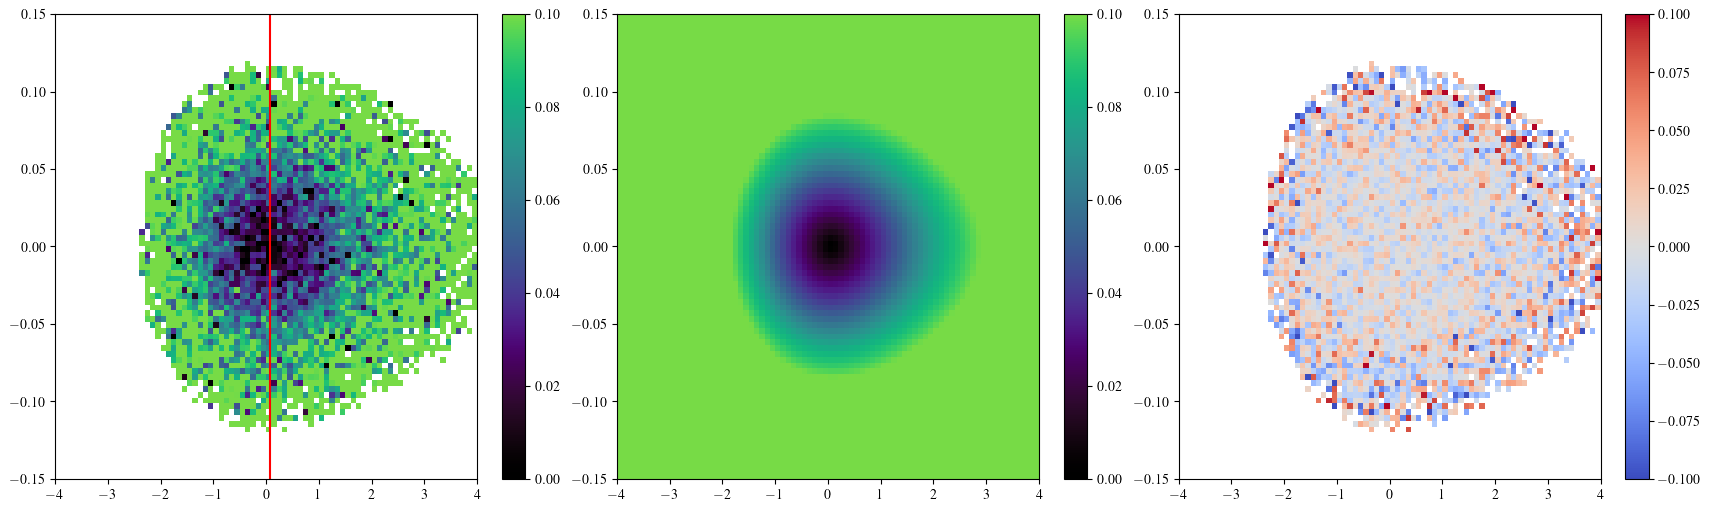

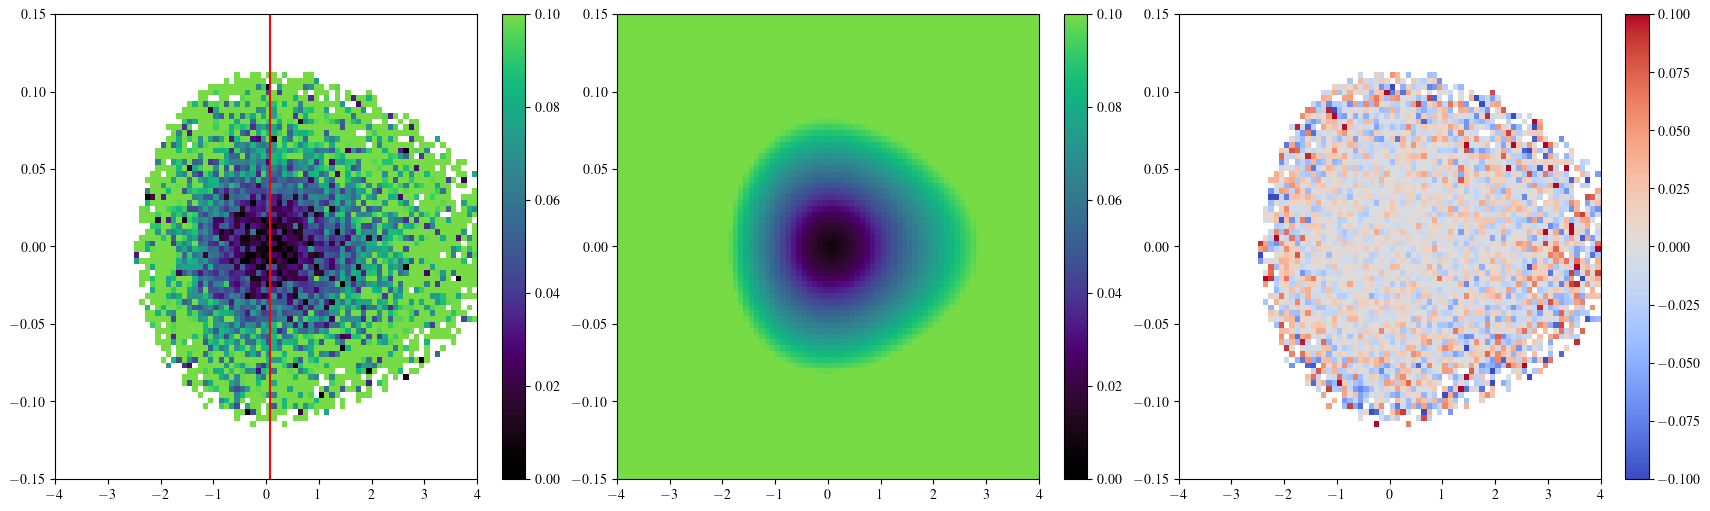

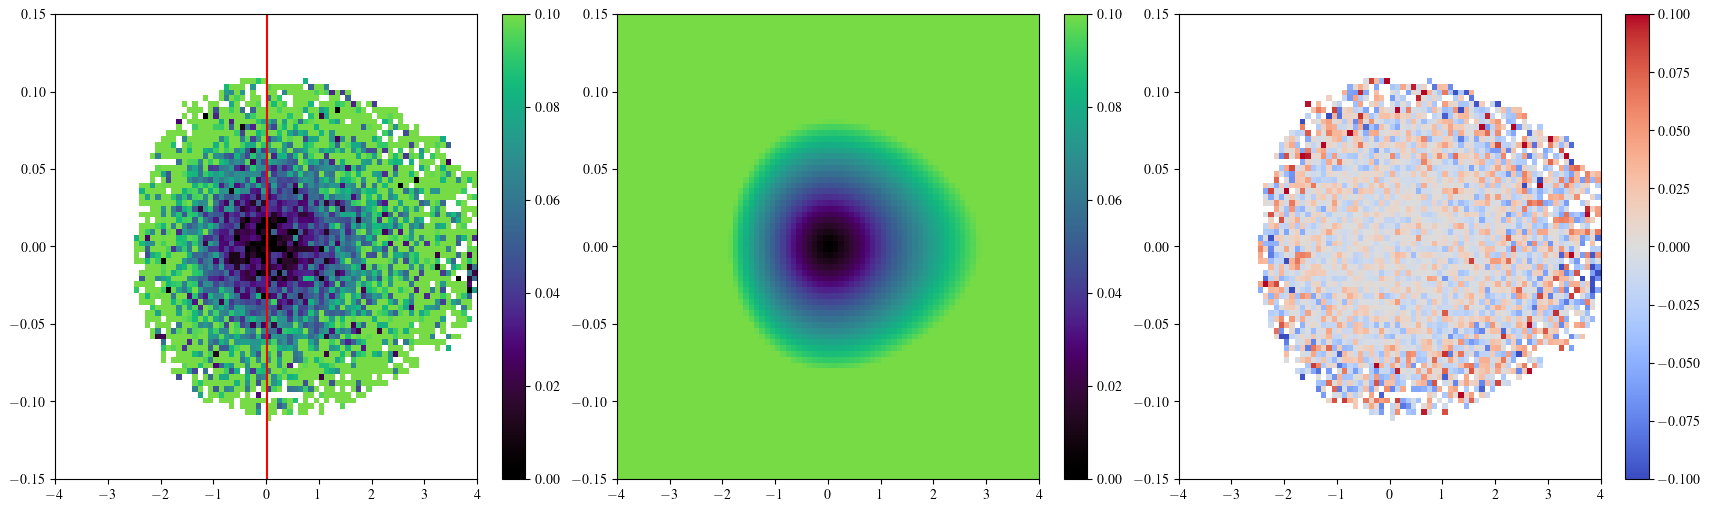

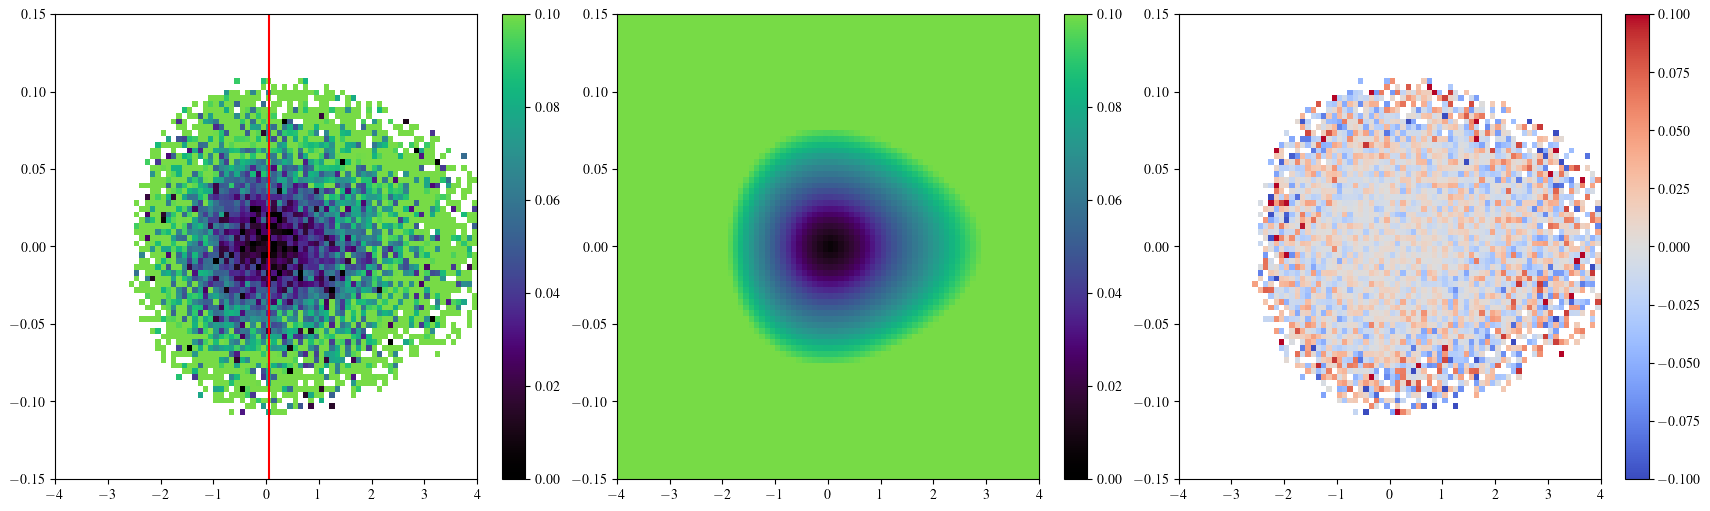

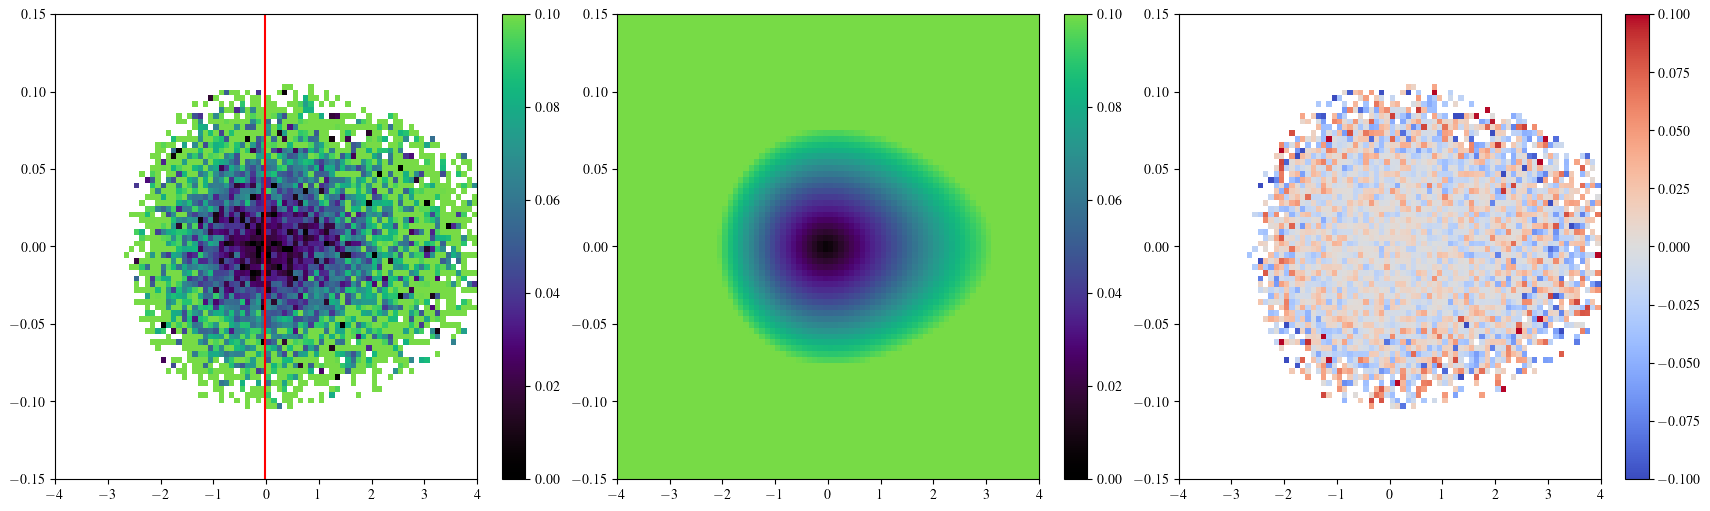

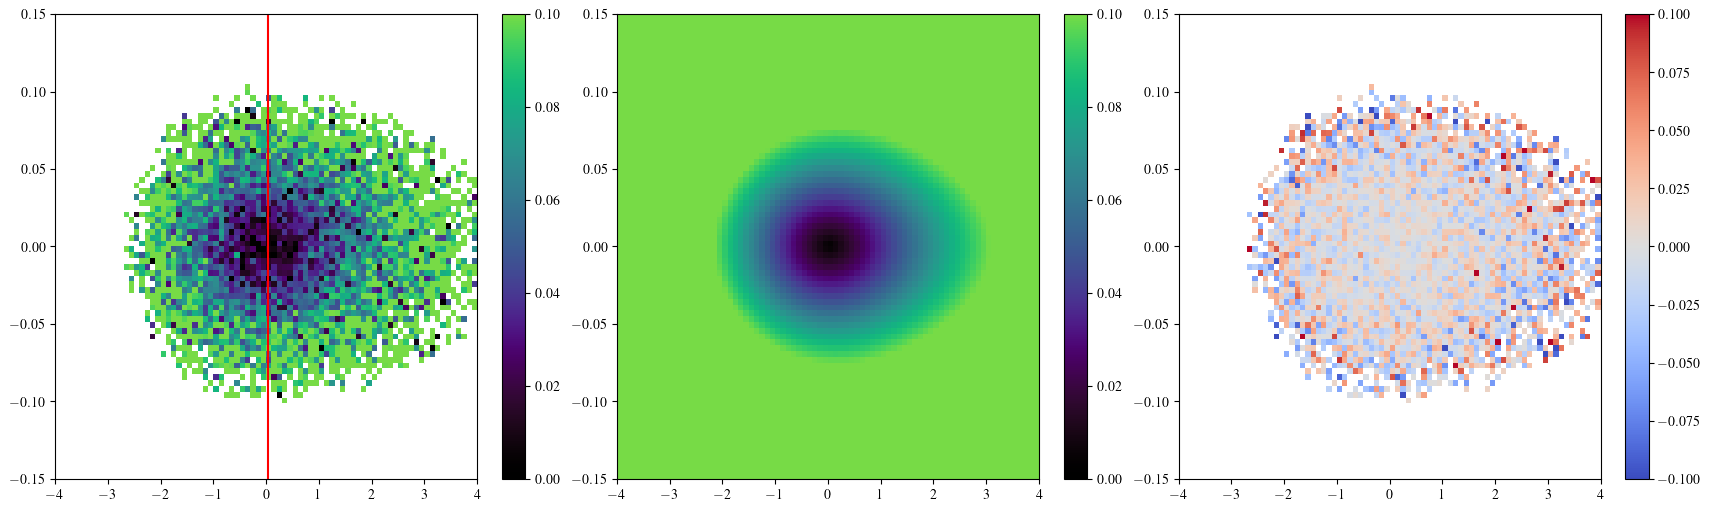

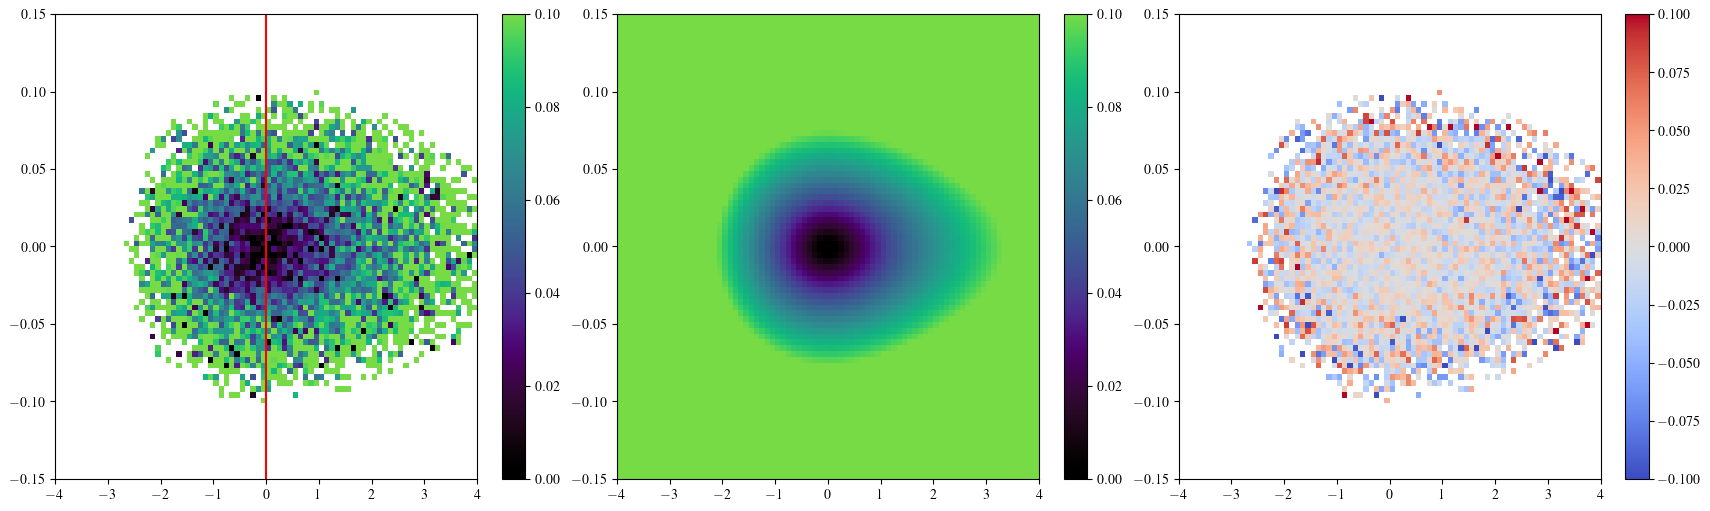

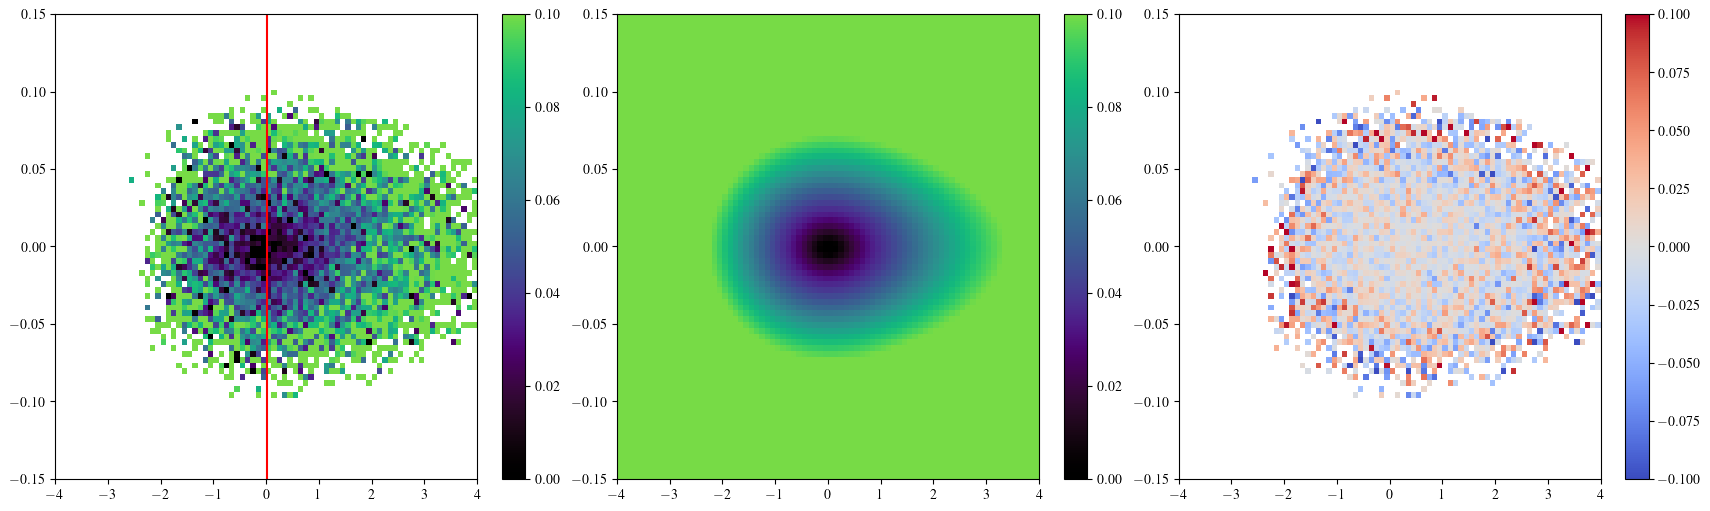

In [19]:
bdatas = []
reses = []

for indx, i in tqdm.tqdm(enumerate(deltaR_boot)):
    x_param = np.array(i[0])*u.kpc
    y_param = np.array(vRs_boot[indx][0]) *u.kpc/u.Myr
    label = np.array(xfe_boot[indx][0])
    label_err = np.array(xfe_err_boot[indx][0])

    bdata = oti.data.get_binned_label(        
        pos=x_param.astype(np.float32),
        vel=y_param.astype(np.float32),
        label=label.astype(np.float32),
        label_err=label_err.astype(np.float32),
        bins=bins,
        units=galactic,
        s_N_thresh=2,
    )

    bdata_clean = dict(
        pos=bdata["pos"],
        vel=bdata["vel"],
        label=bdata["label"],
        label_err=bdata["label_err"],
    )
    bdata_mask = (
        np.isfinite(bdata["label"])
        & np.isfinite(bdata["label_err"])
        & (bdata["label_err"] > 0)
    )
    bdata_clean = {k: v[bdata_mask] for k, v in bdata_clean.items()}

    res = model.optimize(init_params, objective="gaussian", bounds=bounds, **bdata_clean)
    
    # Plot the data 
    fig, axes = plt.subplots(1, 3, figsize=(17, 5), constrained_layout=True)
    cs = axes[0].pcolormesh(
        bdata["pos"].value,
        bdata["vel"].value,
        bdata["label"],
        cmap=cm.lavender,
        vmin=0.0,
        vmax=0.1,
    )
    axes[0].vlines(res.params['pos0'], -0.15,0.15, color='r')
    fig.colorbar(cs, ax=axes[0])

    model_label = model._get_label(pos=bdata["pos"], vel=bdata["vel"], params=res.params)

    cs = axes[1].pcolormesh(
        bdata["pos"].value,
        bdata["vel"].value,
        model_label,
        cmap=cm.lavender,
        vmin=0.0,
        vmax=0.1,
    )
    fig.colorbar(cs, ax=axes[1])

    # for ss in [1, -1]:
    #     axes[1].scatter(ss * 0.1 * np.sqrt(init_Omega.value), 0., color='tab:green')
    #     axes[1].scatter(0., ss * 0.1 / np.sqrt(init_Omega.value), color='tab:green')

    cs = axes[2].pcolormesh(
        bdata["pos"].value, bdata["vel"].value, (bdata["label"]-model_label), cmap='coolwarm',
        vmin=-0.1,
        vmax=0.1,
    )
    fig.colorbar(cs, ax=axes[2])


    bdatas.append(bdata_clean)
    reses.append(res)


# Looks good! Run the model on all bootstrap samples

In [21]:
bdatas_boot = []
reses_boot = []

for indx, i in tqdm.tqdm_notebook(enumerate(deltaR_boot)):
    for jndx, j in enumerate(i):
        
        x_param = j*u.kpc
        y_param = vRs_boot[indx][jndx]*u.km/u.s
        label = xfe_boot[indx][jndx]
        label_err = xfe_err_boot[indx][jndx]

        bdata = oti.data.get_binned_label(
        
        pos=x_param.astype(np.float32),
        vel=y_param.astype(np.float32),
        label=label.astype(np.float32),
        label_err=label_err.astype(np.float32),
        bins=bins,
        units=galactic,
        s_N_thresh=2,
        )

        bdata_clean = dict(
            pos=bdata["pos"],
            vel=bdata["vel"],
            label=bdata["label"],
            label_err=bdata["label_err"],
        )
        bdata_mask = (
            np.isfinite(bdata["label"])
            & np.isfinite(bdata["label_err"])
            & (bdata["label_err"] > 0)
        )
        bdata_clean = {k: v[bdata_mask] for k, v in bdata_clean.items()}

        res = model.optimize(init_params, objective="gaussian", bounds=bounds, **bdata_clean)

        bdatas_boot.append(bdata_clean)
        reses_boot.append(res)

0it [00:00, ?it/s]

In [22]:
# save the values
import pickle

with open('/Users/dhortad/Projects/TorusImaging-radial/sav/reses-boot-simulation.pickle', 'wb') as handle:
    pickle.dump(reses_boot, handle, protocol=pickle.HIGHEST_PROTOCOL)

np.save('/Users/dhortad/Projects/TorusImaging-radial/sav/bdatas-boot-simulation',np.array(bdatas_boot))

In [23]:
pos0s = []
kappas = []

for i in reses_boot:
    pos0s.append(i.params['pos0'])
    kappas.append(np.exp(i.params['ln_Omega0']))

pos0s = np.array(pos0s).reshape(15,10)
kappas = np.array(kappas).reshape(15,10)

In [24]:
Rgal_cs = np.linspace(5,12,15)
bin_centers = Rgal_cs[:-1]+0.5
bin_centers

array([ 5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
       11. , 11.5, 12. ])

In [26]:
pos0s_per = np.nanpercentile(pos0s, [16,50,84], axis=1)
delta_vc = vcirc*(-np.array(pos0s_per[:,:-1])/bin_centers)
vc = vcirc+delta_vc

(200.0, 250.0)

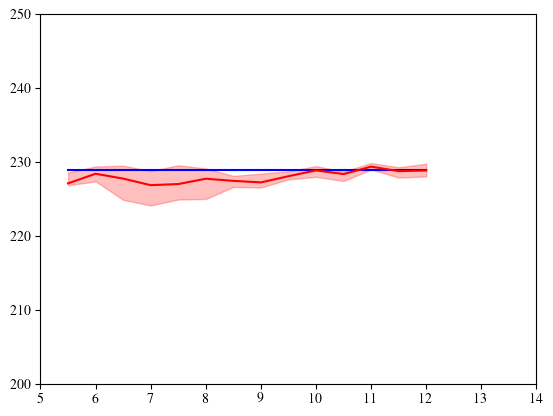

In [29]:
plt.plot(bin_centers, np.tile(vcirc, len(bin_centers)), color='b')
plt.fill_between(bin_centers, vc[0,:].value, vc[2,:].value, color='r', alpha=0.25)
plt.plot(bin_centers, vc[1,:].value, color='r')
plt.xlim(5,14)
plt.ylim(200,250)

Within uncertainties, we can recover rotation curve

# now compute rotation curve from kappa

In [67]:
a_unit = u.km / u.s / u.Myr
x_grid = np.zeros(1) * u.kpc
acc_ = []

for indx, i in enumerate(reses_boot):
    acc_.append(model.get_acceleration(x_grid, i.params).to(a_unit))

In [68]:
acc_ = np.array(acc_).reshape(15,10)
acc_per = np.nanpercentile(acc_.real, [16,50,84], axis=1)

dPhi_dR = -np.array(acc_per[:,:-1]) * a_unit + (bin_centers*u.kpc * (vc)) ** 2 / (bin_centers*u.kpc + x_grid) ** 3
vrot = np.sqrt(bin_centers * u.kpc * dPhi_dR).to_value(u.km/u.s)

In [69]:
import gala.potential as gp

gala_pot = gp.CCompositePotential(
    disk=gp.MiyamotoNagaiPotential(m=6.91e10, a=3, b=0.25, units=galactic),
    halo=gp.NFWPotential(m=5.4e11, r_s=15.0, units=galactic),
)

true_dPhi_dR = gala_pot.gradient(
    np.array([1.0, 0, 0])[:, None] * (bin_centers*u.kpc + x_grid[None])
)[0]
true_vrot = np.sqrt(bin_centers*u.kpc * true_dPhi_dR).to_value(u.km/u.s)


(200.0, 250.0)

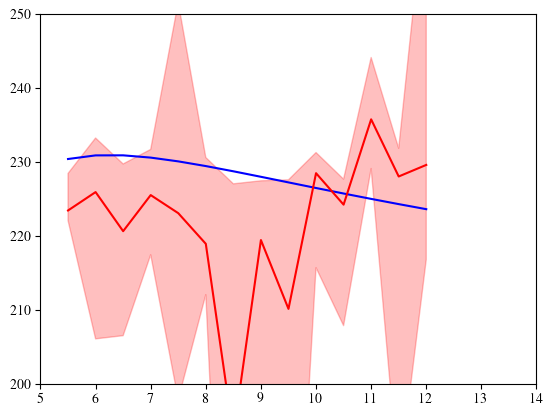

In [70]:
plt.plot(bin_centers, true_vrot, color='b')
plt.fill_between(bin_centers, vrot[0,:], vrot[2,:], color='r', alpha=0.25)
plt.plot(bin_centers, vrot[1,:], color='r')
plt.xlim(5,14)
plt.ylim(200,250)

# now assume a wrong rotation curve

In [45]:
deltaR_boot_w = np.load('../sav/deltaR_boot_w.npy', allow_pickle=True)
vRs_boot_w = np.load('../sav/vRs_boot_w.npy', allow_pickle=True)
xfe_boot_w = np.load('../sav/xfe_boot_w.npy', allow_pickle=True)
xfe_err_boot_w = np.load('../sav/xfe_err_boot_w.npy', allow_pickle=True)
deltaR_boot_w.shape

(15, 10, 50000)

In [46]:
bdatas_boot_w = []
reses_boot_w = []

for indx, i in tqdm.tqdm_notebook(enumerate(deltaR_boot_w)):
    for jndx, j in enumerate(i):
        
        x_param = j*u.kpc
        y_param = vRs_boot_w[indx][jndx]*u.km/u.s
        label = xfe_boot_w[indx][jndx]
        label_err = xfe_err_boot_w[indx][jndx]

        bdata = oti.data.get_binned_label(
        
        pos=x_param.astype(np.float32),
        vel=y_param.astype(np.float32),
        label=label.astype(np.float32),
        label_err=label_err.astype(np.float32),
        bins=bins,
        units=galactic,
        s_N_thresh=2,
        )

        bdata_clean = dict(
            pos=bdata["pos"],
            vel=bdata["vel"],
            label=bdata["label"],
            label_err=bdata["label_err"],
        )
        bdata_mask = (
            np.isfinite(bdata["label"])
            & np.isfinite(bdata["label_err"])
            & (bdata["label_err"] > 0)
        )
        bdata_clean = {k: v[bdata_mask] for k, v in bdata_clean.items()}

        res = model.optimize(init_params, objective="gaussian", bounds=bounds, **bdata_clean)

        bdatas_boot_w.append(bdata_clean)
        reses_boot_w.append(res)

0it [00:00, ?it/s]

In [47]:
# save the values
import pickle

with open('/Users/dhortad/Projects/TorusImaging-radial/sav/reses-boot-simulation-wrongrotcurve.pickle', 'wb') as handle:
    pickle.dump(reses_boot_w, handle, protocol=pickle.HIGHEST_PROTOCOL)

np.save('/Users/dhortad/Projects/TorusImaging-radial/sav/bdatas-boot-simulation-wrongrotcurve',np.array(bdatas_boot_w))

In [48]:
pos0s_w = []
kappas_w = []

for i in reses_boot_w:
    pos0s_w.append(i.params['pos0'])
    kappas_w.append(np.exp(i.params['ln_Omega0']))

pos0s_w = np.array(pos0s_w).reshape(15,10)
kappas_w = np.array(kappas_w).reshape(15,10)

In [49]:
vcirc_w = 210*u.km/u.s

pos0s_per_w = np.nanpercentile(pos0s_w, [16,50,84], axis=1)
delta_vc = vcirc_w*(-np.array(pos0s_per_w[:,:-1])/bin_centers)
vc_w = vcirc_w+delta_vc

(200.0, 250.0)

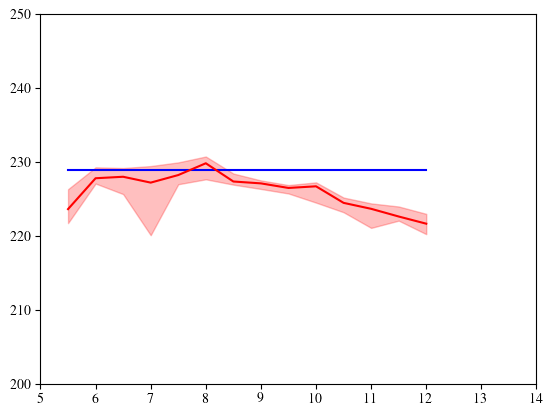

In [50]:
plt.plot(bin_centers, np.tile(vcirc, len(bin_centers)), color='b')
plt.fill_between(bin_centers, vc_w[0,:].value, vc_w[2,:].value, color='r', alpha=0.25)
plt.plot(bin_centers, vc_w[1,:].value, color='r')
plt.xlim(5,14)
plt.ylim(200,250)

In [71]:
a_unit = u.km / u.s / u.Myr
x_grid = np.zeros(1) * u.kpc
acc_w = []

for indx, i in enumerate(reses_boot_w):
    acc_w.append(model.get_acceleration(x_grid, i.params).to(a_unit))

In [73]:
acc_w = np.array(acc_w).reshape(15,10)
acc_per_w = np.nanpercentile(acc_w.real, [16,50,84], axis=1)

dPhi_dR_w = -np.array(acc_per_w[:,:-1]) * a_unit + (bin_centers*u.kpc * (vc_w)) ** 2 / (bin_centers*u.kpc + x_grid) ** 3
vrot_w = np.sqrt(bin_centers * u.kpc * dPhi_dR_w).to_value(u.km/u.s)

(5.0, 14.0)

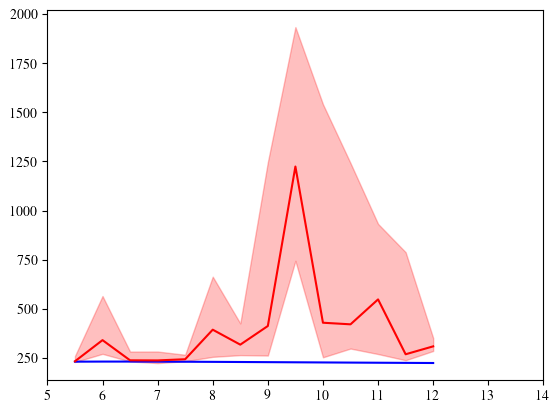

In [75]:
plt.plot(bin_centers, true_vrot, color='b')
plt.fill_between(bin_centers, vrot_w[0,:], vrot_w[2,:], color='r', alpha=0.25)
plt.plot(bin_centers, vrot_w[1,:], color='r')
plt.xlim(5,14)
# plt.ylim(200,250)

In [76]:
vrot_w[1,:]

array([ 232.46803234,  340.10240383,  237.34607454,  236.83628475,
        242.84646901,  393.27918498,  317.10560694,  412.06486193,
       1224.06398451,  428.71783811,  420.58699502,  547.4963302 ,
        268.18231977,  308.44081538])